# Modeling Walkthrough II - Predicting the Proportion of Votes 

In this notebook, we are going to predict the proportion of votes attained by each party in each constituency. We will be incorporating a few more features into our model fit and using some data that has been preprocessed and can be found in the *data* folder of the [Github repository](https://github.com/MangoTheCat/rss-2018-hackathon). This type of prediction requires regression and as such we are going to use a Linear Regressor.

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, model_selection

# Setup
pd.set_option('display.max_columns', None)

### Importing and Exploring

First, we import our model ready data and have a look at what we are dealing with.

In [49]:
df = pd.read_csv('data/ge_2010_2015_training_data.csv')
df.head(15)

,Press Association Reference,Constituency Name,Region,Electorate,Votes,party,votes_last,pc_last,win_last,polls_now,swing_now,swing_forecast_pc,swing_forecast_win,actual_win_now,actual_pc_now,con,grn,lab,ld,ukip,Region_East Midlands,Region_Eastern,Region_London,Region_North East,Region_North West,Region_Northern Ireland,Region_Scotland,Region_South East,Region_South West,Region_Wales,Region_West Midlands,Region_Yorkshire and the Humber,won_here_last
0,1.0,Aberavon,Wales,50838.0,30958,con,4411.0,0.142483,lab,0.338182,-0.062021,0.133646,lab,lab,0.118707,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.0,Aberavon,Wales,50838.0,30958,lab,16073.0,0.519187,lab,0.337273,0.163400,0.604022,lab,lab,0.489040,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,1.0,Aberavon,Wales,50838.0,30958,ld,5034.0,0.162607,lab,0.090000,-0.609159,0.063554,lab,lab,0.044317,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.0,Aberavon,Wales,50838.0,30958,ukip,489.0,0.015796,lab,0.127273,3.109344,0.064910,lab,lab,0.157694,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1.0,Aberavon,Wales,50838.0,30958,grn,0.0,0.000000,lab,0.048182,4.008203,0.000000,lab,lab,0.022555,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,2.0,Aberconwy,Wales,44593.0,29966,con,10734.0,0.358206,con,0.338182,-0.062021,0.335990,con,con,0.415052,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6,2.0,Aberconwy,Wales,44593.0,29966,lab,7336.0,0.244811,con,0.337273,0.163400,0.284813,con,con,0.282407,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,2.0,Aberconwy,Wales,44593.0,29966,ld,5786.0,0.193085,con,0.090000,-0.609159,0.075466,con,con,0.046139,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,2.0,Aberconwy,Wales,44593.0,29966,ukip,632.0,0.021091,con,0.127273,3.109344,0.086668,con,con,0.114999,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
9,2.0,Aberconwy,Wales,44593.0,29966,grn,0.0,0.000000,con,0.048182,4.008203,0.000000,con,con,0.024114,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


From this, we can see that for each constituency, we have five rows defined by the party that is being represented. This assumes that the data for each party in each constituency is independent of each other.

Notable additions to the data:
* Polling data: We have `polls_now` which gives us the proportional polling data
* Swing data: We have `swing_now` which gives us the change in proportion of votes between the last election and the polls preceeding the current election, `swing_forecast_pc` gives us the forecasted change in proportion of votes from now to the election
* `won_here_last` gives us whether or not the same party won the last election
* `actual_pc_now` gives us our target variable; the proportion of votes attained in the election in this constituency by this party.

Now, we are going to use seaborn to visualise the relationships between our features. Using this, we can see how useful they are going to be to our model.

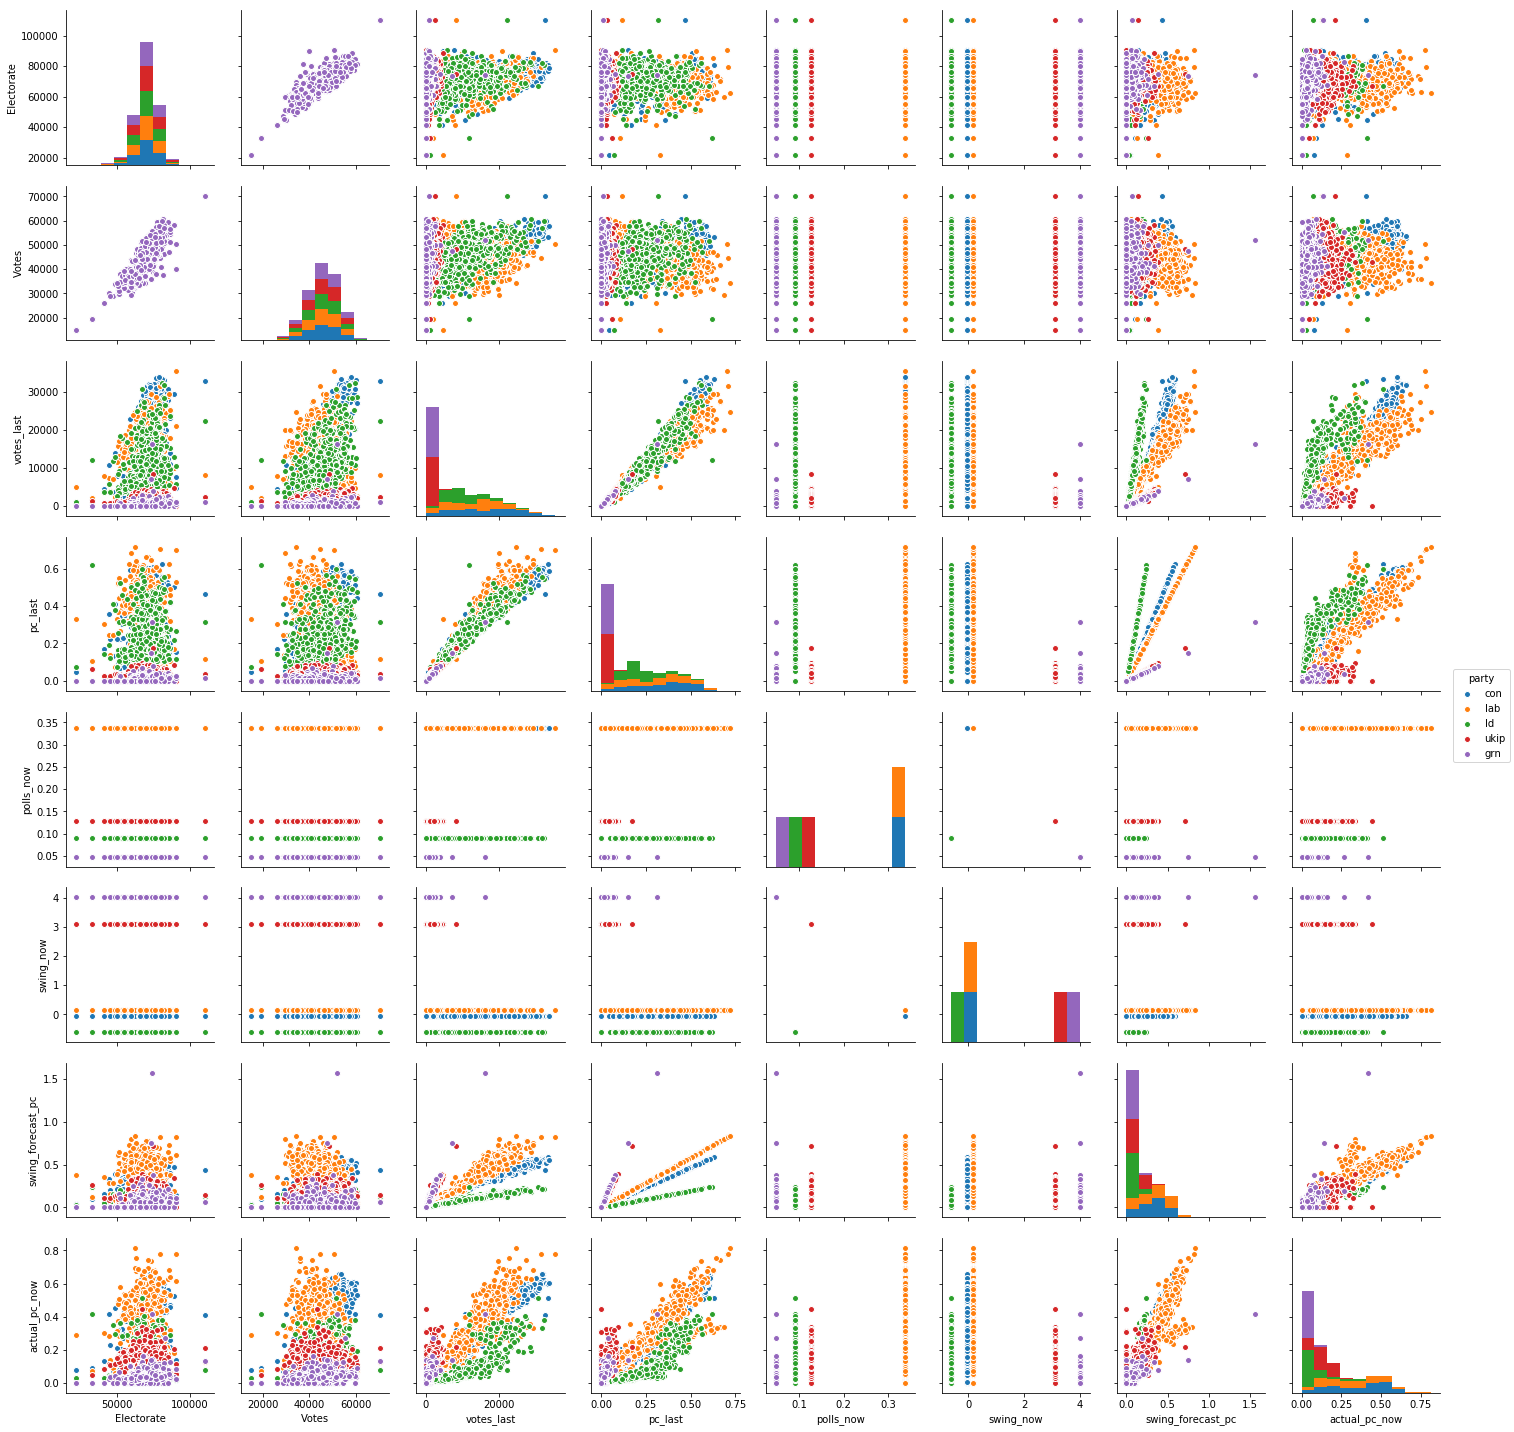

In [50]:
sns.pairplot(df[['Electorate', 'Votes', 'votes_last', 'pc_last', 'polls_now', 'swing_now', 'swing_forecast_pc', 'actual_pc_now', 'party']],
             hue='party')

## Swing or no Swing?

Now we are going to use evaluate the use of *swing* in our model by seeing how effective it is in predicting the number of seats won by each party nationally. We do this by comparing *swing_forecast_win* with the actual results of the 2015 election.

In [30]:
parties = ['con', 'lab', 'ld', 'ukip', 'grn']

In [79]:
# Seats won in 2010
(df[['Constituency Name', 'win_last']]
    .drop_duplicates()
    .groupby('win_last')
    .count()
    .sort_values('Constituency Name', ascending=False)
)

,Constituency Name
win_last,
con,306
lab,258
ld,57
DUP,8
SNP,6
SF,5
PC,3
SDLP,3
APNI,1


In [81]:
# Seats forecast to win in 2015 using swing
(df[['Constituency Name', 'swing_forecast_win']]
    .drop_duplicates()
    .groupby('swing_forecast_win')
    .count()
    .sort_values('Constituency Name', ascending=False)
)

,Constituency Name
swing_forecast_win,
lab,325
con,294
other,25
grn,3
ukip,2
ld,1


In [33]:
# Seats actually won in 2015 (from election results)
(df[['Constituency Name', 'actual_win_now']]
    .drop_duplicates()
    .groupby('actual_win_now')
    .count()
    .sort_values('Constituency Name', ascending=False)
)

,Constituency Name
actual_win_now,
con,330
lab,232
snp,56
DUP,8
ld,8
SF,4
SDLP,3
pc,3
UUP,2


Next, we calculate the difference in proportion of votes actually attained and the proportion stated in *swing_forecast_pc*. 

In [83]:
# Total average error per party per seat
(df[['Constituency Name', 'actual_pc_now', 'swing_forecast_pc']]
    .apply(lambda row: abs(row['actual_pc_now'] - row['swing_forecast_pc']), axis=1)
    .mean()
)

0.044484066758131297

This tells us that *swing* is going to be very useful in predicting the proportion of votes and so we will use it as a feature.

## Making Predictions

In this section we are going to fit our model, make predictions and calculate how accurate our model fit was by comparing it with the actual results.

In [36]:
model = linear_model.LinearRegression()

We define the features we use below:

In [75]:
features= parties + ['Electorate', 'Votes', 'votes_last', 'pc_last', 'won_here_last',
         'polls_now', 'swing_now', 'swing_forecast_pc']

Now, we define a function `score_model` to help us *cross_validate* our model using K Fold Cross Validation. What this means is that we take our data set and do the following:

* Split it into K parts
* Train our model on K-1 of those parts
* Test our model on the last part
* Calculate the error of our model

We repeat these steps a few times and average our error.

In [77]:
# Some useful functions
def score_model(model, X, y, repeats=5):
    """Calculates a "5x5" (repeated 5-fold) cross-validated shuffled mean average error.
       Returns the mean across 5 (default) repeats."""
    mae = []
    for i in range(repeats):
        mae += [-np.mean(model_selection.cross_val_score(model, X=X, y=y, cv=model_selection.KFold(n_splits=5, shuffle=True), scoring='neg_mean_absolute_error'))]
    mean = np.mean(mae)
    return mean


Let's call the function on our model.

In [78]:
score_model(model, df[features], df['actual_pc_now'])

0.032874637931362916

Wow! We get a mean absolute error of around 3%. That's awesome.

So what's next..?

## Extensions

You can fork this notebook and pick up where we left off by trying out some new models, or improve this one.

Or choose something else to predict, like maybe using the model_2015 dataset to predict how people voted in the EU referendum.

The possibilities are endless!